In [159]:
import numpy as np
import geopandas as gp
import pandas as pd
import datetime as dt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

# import .py scripts from repo 
from json_to_csv import geojson_to_csv
from ts_train_test_split import uni_selection
from ts_train_test_split import single_split

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18})

## Import necessary files

``Locations.csv`` for metadata, from that file we can import and process the desired dataset. From the ``model-accuracy.csv`` we can find the location with the best r2 value for the SARIMAX model, so I chose Wilbur, WA. 

In [163]:
locations = pd.read_csv('model-accuracy.csv')
locations

,lat,lon,Place,p,d,q,P,D,Q,filepath,MSE,r2
0,49.0362,-122.3247,"Abbotsford, Canada",3,1,3,1,1,0,NASA/POWER_Point_Monthly_Timeseries_1981_2020_...,0.005196,0.393463
1,49.0362,-118.4245,"Grand Forks, Canada",7,0,8,0,1,1,NASA/POWER_Point_Monthly_Timeseries_1981_2020_...,0.003308,0.617231
2,48.9289,-117.8306,"Northport, WA",6,1,7,2,0,0,NASA/POWER_Point_Monthly_Timeseries_1981_2020_...,0.005505,0.546679
3,48.7835,-122.3357,"Dewey, WA",8,0,6,1,1,0,NASA/POWER_Point_Monthly_Timeseries_1981_2020_...,0.003690,0.593348
4,48.7826,-121.7994,"Mt. Baker, WA",8,1,8,0,0,2,NASA/POWER_Point_Monthly_Timeseries_1981_2020_...,0.004682,0.468024
5,48.5767,-122.9509,"Shaw Island, WA",7,0,7,1,1,0,NASA/POWER_Point_Monthly_Timeseries_1981_2020_...,0.003606,0.602567
6,48.5085,-117.3252,"Rudy, WA",8,1,5,1,1,2,NASA/POWER_Point_Monthly_Timeseries_1981_2020_...,0.003135,0.741865
7,48.4093,-123.5716,"Metchosin, Canada",7,1,4,1,1,0,NASA/POWER_Point_Monthly_Timeseries_1981_2020_...,0.003992,0.560085
8,48.0139,-123.4453,"Port Angeles, WA",7,1,8,0,1,0,NASA/POWER_Point_Monthly_Timeseries_1981_2020_...,0.003449,0.619905
9,47.9735,-122.2038,"Everett, WA",4,0,5,0,1,0,NASA/POWER_Point_Monthly_Timeseries_1981_2020_...,0.005012,0.377941


In [164]:
locations.loc[22]

lat                                                   46.2199
lon                                                 -119.0837
Place                                           Kennewick, WA
p                                                           5
d                                                           0
q                                                           8
P                                                           0
D                                                           1
Q                                                           1
filepath    NASA/POWER_Point_Monthly_Timeseries_1981_2020_...
MSE                                                  0.001809
r2                                                   0.847071
Name: 22, dtype: object

Choosing the Wilbur, WA dataset and converting to a pandas dataframe, then creating a new dataframe ``Y`` with just the ALLSKY_KT column of interest and assigning the frequency for the SARIMAX model:

In [165]:
df = geojson_to_csv(locations['filepath'][22])
#df

In [166]:
Y = uni_selection(df)
Y.index = pd.DatetimeIndex(X.index.values,
                           freq=X.index.inferred_freq)

## Time Series train-test split

using ``sklearn`` ``TimeSeriesSplit``, define the parameters for the expanding-window split series.

In this case, we chose 8 splits, with a ``test_size`` of 48 (months, aka 4 years). 

In [11]:
tscv = TimeSeriesSplit(max_train_size=396, n_splits=8, test_size=48)
tscv

TimeSeriesSplit(gap=0, max_train_size=396, n_splits=8, test_size=48)

Because ``Y`` is the entire dataframe, it didn't process correctly in the function. Therefore ``X`` was used in the function, which selected only the column.

In [167]:
X = Y['ALLSKY_KT']

## The Function:

``window_validation`` requires only one input: ``X``. It returns two dataframes: ``results`` and ``values``. ``results`` is a df with the mse and r2 for each train-test split, and ``values`` returns a df of the final train-test split with the X_test (aka real) values for each month and the predicted values for each month.

In [172]:

def window_validation(X):
    MSEs = []
    r2s = []
    train_size = []
    tscv = TimeSeriesSplit(max_train_size=396, n_splits=8, test_size=48)
    
    for train_index, test_index in tscv.split(X):
        #print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train, X_test = X[train_index], X[test_index]
        model = SARIMAX(X_train, order = (5,0,8), seasonal_order = (0,1,1,12))
        model_fit = model.fit(maxiter=50, method='powell', disp = False)
        predict = model_fit.predict(start=test_index[0], end=test_index[47])
        MSE = mean_squared_error(X_test, predict)
        r2 = r2_score(X_test, predict)
        X_test = pd.DataFrame([X_test]).T
        prediction = pd.DataFrame(predict)
        prediction.index = pd.DatetimeIndex(X_test.index.values, freq=X_test.index.inferred_freq)
        values = pd.concat([X_test, prediction], keys=['real', 'predicted'], axis=1)
        #values.columns = together.columns.droplevel(1)
        train_size.append(len(X_train))
        MSEs.append(MSE)
        r2s.append(r2)
    MSEs = pd.DataFrame([MSEs]).T
    r2s = pd.DataFrame([r2s]).T
    train_size = pd.DataFrame([train_size]).T
    results = pd.concat([train_size, MSEs, r2s], keys=['train_size', 'MSE', 'r2'], axis=1)
    results.columns = results.columns.droplevel(1)
    return results, values

In [173]:
kennewick, values = window_validation(X)

/home/cbenstead/miniconda3/envs/SERF/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [177]:
kennewick

,train_size,MSE,r2
0,60,0.001571,0.731979
1,108,0.001897,0.628381
2,156,0.001610,0.767758
3,204,0.004382,0.664978
4,252,0.001682,0.854293
5,300,0.001346,0.871936
6,348,0.002082,0.800905
7,396,0.001808,0.847125


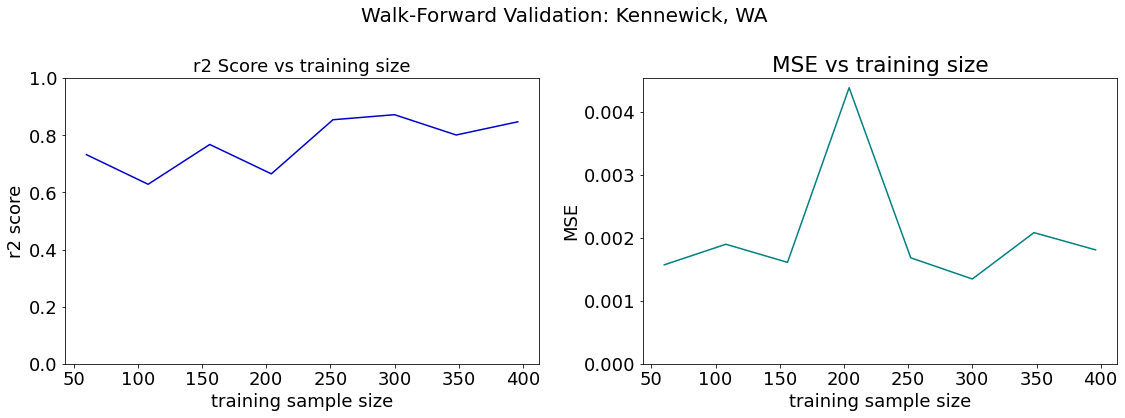

In [179]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

plt.suptitle('Walk-Forward Validation: Kennewick, WA', fontsize=20)

ax[0].plot(kennewick['train_size'], kennewick['r2'], color='mediumblue')
ax[0].set_xlabel('training sample size')
ax[0].set_ylabel('r2 score')
ax[0].set_title(label='r2 Score vs training size', fontsize=18)
ax[0].set_ylim([0,1])

ax[1].plot(kennewick['train_size'], kennewick['MSE'], color='teal')
ax[1].set_xlabel('training sample size')
ax[1].set_ylabel('MSE')
ax[1].set_title(label='MSE vs training size')
ax[1].set_ylim(bottom=0)

fig.tight_layout()


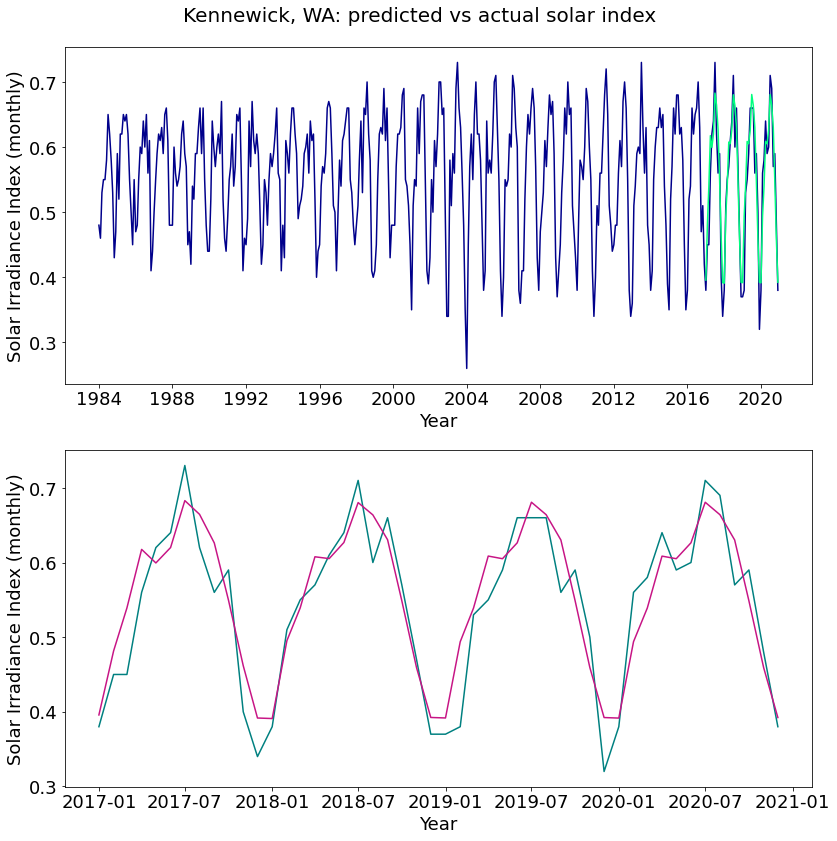

In [180]:
fig2, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,12))

plt.suptitle('Kennewick, WA: predicted vs actual solar index', fontsize=20)
axes[0].plot(Y, color='darkblue', label='dataset')
axes[0].plot(values['predicted'], color='springgreen', label='predicted')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Solar Irradiance Index (monthly)')

axes[1].plot(values['real'], color='teal', label='actual values')
axes[1].plot(values['predicted'], color='mediumvioletred', label='predicted')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Solar Irradiance Index (monthly)')

fig2.tight_layout()